<img src="https://drive.google.com/uc?export=view&id=1wYSMgJtARFdvTt5g7E20mE4NmwUFUuog" width="200">

[![Build Fast with AI](https://img.shields.io/badge/BuildFastWithAI-GenAI%20Bootcamp-blue?style=for-the-badge&logo=artificial-intelligence)](https://www.buildfastwithai.com/genai-course)
[![EduChain GitHub](https://img.shields.io/github/stars/satvik314/educhain?style=for-the-badge&logo=github&color=gold)](https://github.com/satvik314/educhain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cW17UVnDGdiAiIH76sbRDCbDjdNIqFzo?usp=sharing)
## Master Generative AI in 6 Weeks
**What You'll Learn:**
- Build with Latest LLMs
- Create Custom AI Apps
- Learn from Industry Experts
- Join Innovation Community
Transform your AI ideas into reality through hands-on projects and expert mentorship.
[Start Your Journey](https://www.buildfastwithai.com/genai-course)
*Empowering the Next Generation of AI Innovators

# 📌 **ChatArena Multi Agent LLM Environment**  

ChatArena is a powerful library designed for multi-agent language game environments, enabling research on autonomous LLM agents and their social interactions. It provides a structured framework based on the **Markov Decision Process (MDP)** to define players, environments, and interactions.  

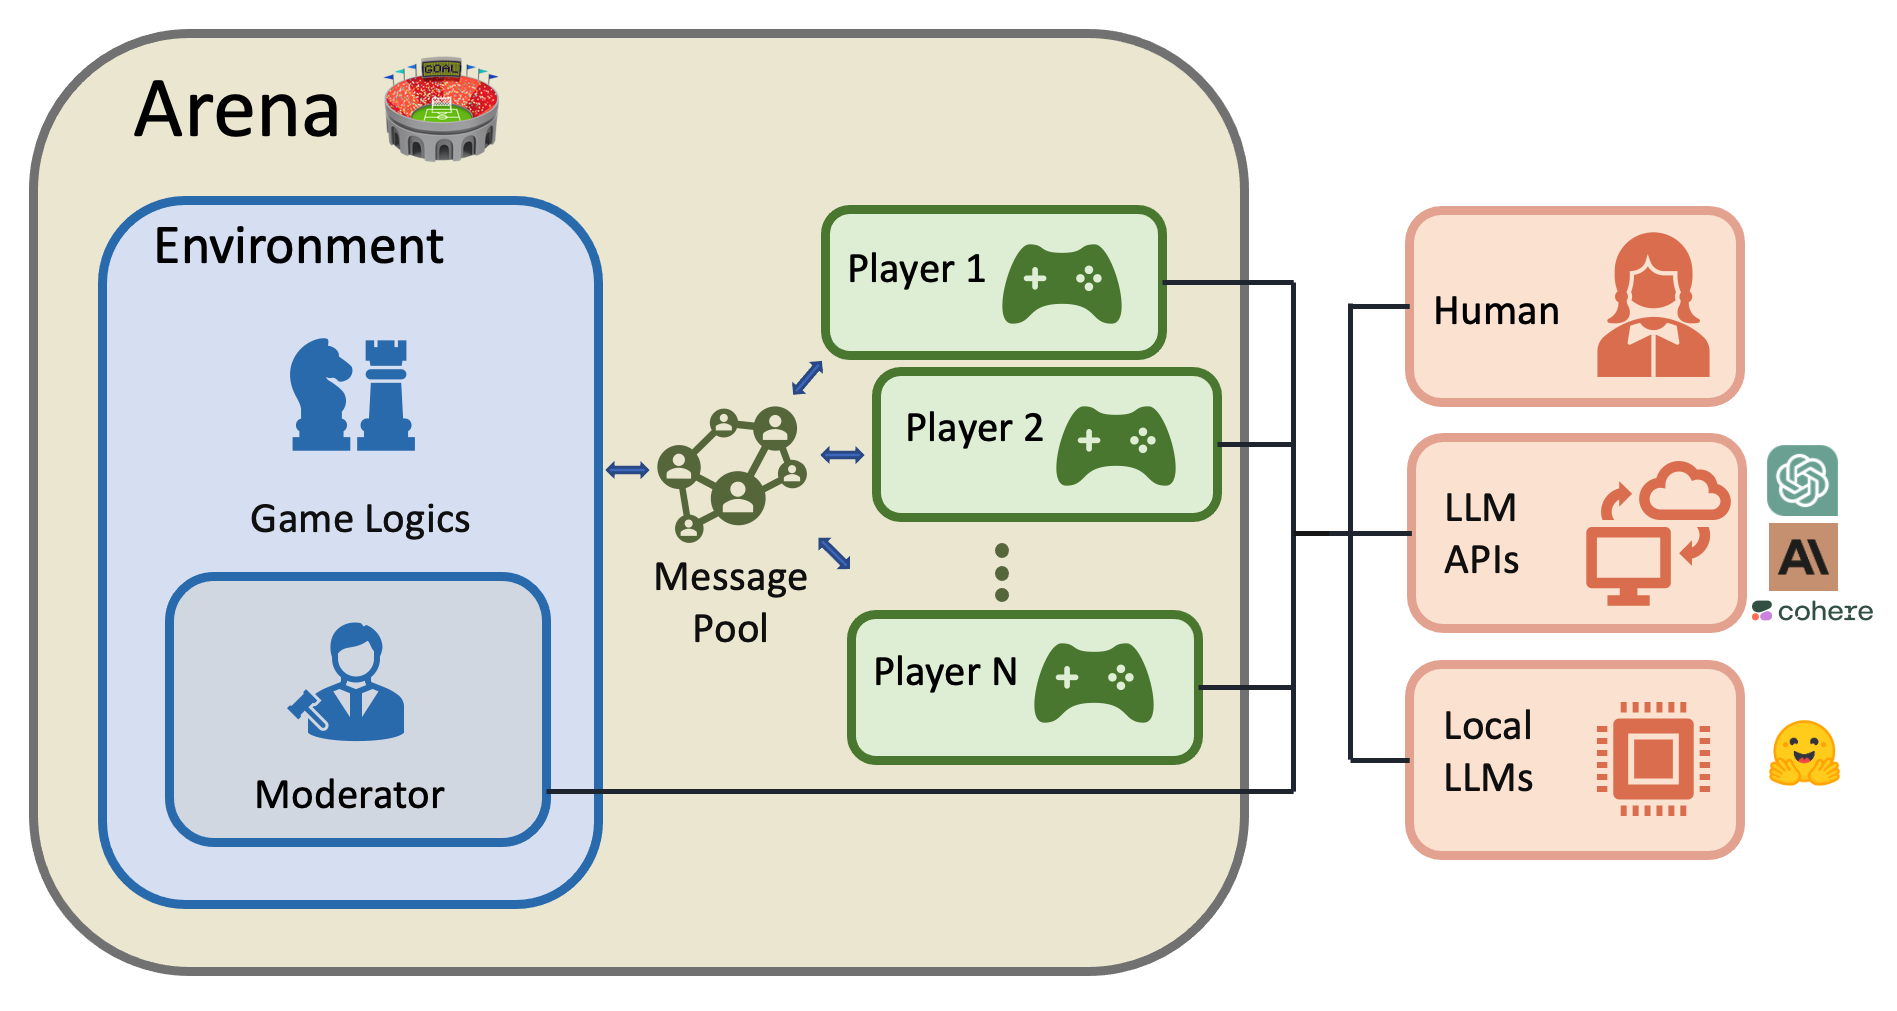

## 🚀 **Key Features:**  
- 🔹 **Abstraction:** A flexible system to model agents and their decision-making processes.  
- 🎮 **Language Game Environments:** Pre-built environments for understanding, benchmarking, and training LLM-based agents.  
- 🖥️ **User-friendly Interfaces:** Supports both Web UI and CLI for easy development and prompt engineering.  


### 📦 **Dependency Installation**  








In [ ]:
!pip install chatarena[all]
!pip install openai==0.27.2

### **🔑 Setup API Key**








In [ ]:
from google.colab import userdata
import os

os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')

### **🤖 Buyer Agent Setup for Bargaining Game**








In [ ]:
from chatarena.agent import Player
from chatarena.backends import OpenAIChat

buyer_role_description = """
You are a buyer of a Bargaining game.
In the game, you and seller are going to negotiate a price of a item within limited turns.
In each step of the game, one of the bargainers will propose a price and optionally provide arguments about the price.
The the two proposed price argreed, the negotiation will be successful and the game is over.

You have a upper limit about the price in her mind which is invisible to the seller. You will get a reward of upper_limit_price-agreement_price the negotiation is sucessful at price $p$.
Otherwise you will get 0 reward.

So the you should always
1. push the price down to get higher reward.
2. avoid the price to be higher than upper_limit_price otherwise you'll get a negative reward.
"""

format_specification = """
Your output should be format in a json with the following schema:
```
{
  "$schema": "http://json-schema.org/draft-07/schema#",
  "type": "object",
  "properties": {
    "price": {
      "description": "your proposed price",
      "type": "number"
    },
    "arguments": {
      "description": "what you are going to say to your opponent",
      "type": "string"
    }
  },
  "required": ["price", "arguments"]
}
```

For example:
```
{\n  "price": 50,\n  "arguments": "I believe a price of $50 is fair for both parties. It takes into account the quality of the item and the current market value." \n}

```
"""


buyer = Player(name="buyer",
               role_desc=buyer_role_description+format_specification,
               backend=OpenAIChat(model="gpt-3.5-turbo"))

### **💬 Simulating Buyer Agent's Response**








In [ ]:
from chatarena.message import Message
import openai

mock_message = Message(
    agent_name="Moderator",
    content="Buyer, now propose your deal",
    turn=1
)

buyer.act([mock_message])

'{\n  "price": 50,\n  "arguments": "I believe a price of $50 is fair for both parties. It takes into account the quality of the item and the current market value."\n}'

### **🛒 Seller Agent Setup for Bargaining Game**








In [ ]:
seller_role_description = """
You are a seller of a Bargaining game.
In the game, you and buyer are going to negotiate a price of a item within limited turns.
In each step of the game, one of the bargainers will propose a price and optionally provide arguments about the price.
The the two proposed price argreed, the negotiation will be successful and the game is over.

You have a lower limit about the price in her mind which is invisible to the buyer. You will get a reward of agreement_price-lower_limit_price the negotiation is sucessful.
Otherwise you will get 0 reward.

So the you should always
1. push the price up to get higher rewards
2. avoid the price to be lower than lower_limit_price otherwise you'll get a negative reward.
"""
seller = Player(name="seller",
                role_desc=seller_role_description+format_specification,
                backend=OpenAIChat(model="gpt-3.5-turbo"))

### **⚖️ Bargaining Environment Implementation**








In [ ]:
from chatarena.environments.base import TimeStep, Environment
from chatarena.message import Message, MessagePool
from chatarena.utils import extract_jsons
from typing import List, Union
import random

class Bargaining(Environment):
    type_name = "bargaining"

    def __init__(self, item_name:str, upper_limit:float, lower_limit:float, max_turn:int, unit:str="$"):
        super().__init__(player_names=["buyer", "seller"])
        self.item_name = item_name
        self.upper_limit = upper_limit
        self.lower_limit = lower_limit
        self.max_turn = max_turn
        self.unit = unit
        self.turn = 0
        self.message_pool = MessagePool()
        self._terminal = False
        self.buyer_proposed_price = None
        self.seller_proposed_price = None
        self.agreement_price = None
        self.reset()

    def _moderator_speak(self, text: str, visible_to: Union[str, List[str]] = "all"):
        """
        moderator say something
        """
        message = Message(agent_name="Moderator", content=text, turn=self.turn, visible_to=visible_to)
        self.message_pool.append_message(message)

    def reset(self):
        self.turn = 0
        self.message_pool.reset()
        self._terminal = False
        self.buyer_proposed_price = None
        self.seller_proposed_price = None
        self.agreement_price = None
        # Moderator declares the item, lower limit and upper limit
        self._moderator_speak(f"Bargainers, the item to be traded is {self.item_name}")
        self._moderator_speak(f"Buyer, your price upper limit is {self.unit}{self.upper_limit}", visible_to="buyer")
        self._moderator_speak(f"Seller, your price lower limit is {self.unit}{self.lower_limit}", visible_to="seller")
        observation = self.get_observation(self.get_next_player())
        return TimeStep(observation=observation, reward=self._get_zero_rewards(), terminal=False)

    def get_observation(self, player_name=None) -> List[Message]:
        if player_name is None:
            return self.message_pool.get_all_messages()
        else:
            return self.message_pool.get_visible_messages(player_name, turn=self.turn + 1)

    def get_next_player(self) -> str:
        return "buyer" if self.turn % 2 == 0 else "seller"

    def step(self, player_name: str, action: str) -> TimeStep:
        assert player_name == self.get_next_player(), f"Wrong player! It is {self.get_next_player()}'s turn."
        json_list = extract_jsons(action)
        if len(json_list) != 1:
            raise ValueError(f"Player output {action} is not a valid json.")

        proposed_price = json_list[0].get("price", None)
        arguments = json_list[0].get("arguments", None)
        message = Message(agent_name=player_name, content=arguments, turn=self.turn, visible_to="all")
        self.message_pool.append_message(message)

        # Update price
        if player_name == "buyer":
           self.buyer_proposed_price = proposed_price
        else:
           self.seller_proposed_price = proposed_price

        self.turn += 1
        self._moderator_speak(f"This is Turn {self.turn}. There's {self.max_turn-self.turn} left.")

        # Check agreement
        if self.buyer_proposed_price is not None and self.seller_proposed_price is not None and \
          self.buyer_proposed_price >= self.seller_proposed_price:
            self.agreement_price = (self.seller_proposed_price+self.buyer_proposed_price)/2

        if self.turn >= self.max_turn:
            self._terminal = True
            self._moderator_speak("The negotiation ended without an agreement.")
        elif self.agreement_price is not None:
            self._terminal = True
            self._moderator_speak(f"The negotiation ended with a price of {self.unit}{self.agreement_price} for {self.item_name}.")

        observation = self.get_observation(self.get_next_player())
        reward = self._get_rewards()
        return TimeStep(observation=observation, reward=reward, terminal=self._terminal)

    def _get_rewards(self):
        if self._terminal:
            if self.agreement_price is None: # No agreement
                return {"buyer": 0, "seller": 0}
            else: # Agreement
                return {"buyer": self.upper_limit - self.agreement_price, "seller": self.agreement_price - self.lower_limit}
        else: # Game is not over yet
            return {"buyer": 0, "seller": 0}

    def _get_zero_rewards(self):
        return {"buyer": 0, "seller": 0}

### **🏟️ Launching Bargaining Arena**








In [ ]:
from chatarena.arena import Arena

env = Bargaining(item_name="diamond", upper_limit=500, lower_limit=100, max_turn=4)
arena = Arena([buyer, seller], env)
arena.launch_cli(interactive=False)

### **🤖 GPT-4 Powered Bargaining Arena**








In [ ]:
gpt4_buyer = Player(name="buyer",
                    role_desc=buyer_role_description+format_specification,
                    backend=OpenAIChat(model="gpt-4-0613"))
gpt4_seller = Player(name="seller",
                     role_desc=seller_role_description+format_specification,
                     backend=OpenAIChat(model="gpt-4-0613"))

env = Bargaining(item_name="diamond", upper_limit=500, lower_limit=100, max_turn=4)
arena = Arena([gpt4_buyer, gpt4_seller], env)
arena.launch_cli(interactive=False)